## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [16]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [17]:
train, test = keras.datasets.cifar10.load_data()

In [18]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [19]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [26]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layer'+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layer'+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units,
                             activation='softmax',
                             name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [21]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [37]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(gamma=2., alpha=4., ce_weights=1):
    """Define the customized loss."""
    gamma = float(gamma)
    alpha = float(alpha)
    #fl
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        
        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.math.subtract(1., model_out), gamma)) #tf.pow(x,y)=>x^y
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return (ce_weights*ce + (1-ce_weights)*tf.reduce_mean(reduced_fl))
    
    
    return  focal_loss_fixed
    


ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [38]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(ce_weights=ce_w), metrics=['accuracy'], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_20 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_21 (

49/49 [==============================] - 4s 77ms/step - loss: 1.7942 - accuracy: 0.6369 - val_loss: 2.7881 - val_accuracy: 0.4780
Epoch 14/25
49/49 [==============================] - 4s 74ms/step - loss: 1.7161 - accuracy: 0.6484 - val_loss: 2.8060 - val_accuracy: 0.4794
Epoch 15/25
49/49 [==============================] - 4s 79ms/step - loss: 1.6395 - accuracy: 0.6599 - val_loss: 2.9432 - val_accuracy: 0.4745
Epoch 16/25
49/49 [==============================] - 5s 97ms/step - loss: 1.5678 - accuracy: 0.6727 - val_loss: 2.8861 - val_accuracy: 0.4794
Epoch 17/25
49/49 [==============================] - 4s 77ms/step - loss: 1.4915 - accuracy: 0.6844 - val_loss: 2.8763 - val_accuracy: 0.4757
Epoch 18/25
49/49 [==============================] - 4s 75ms/step - loss: 1.4167 - accuracy: 0.6960 - val_loss: 2.9101 - val_accuracy: 0.4774
Epoch 19/25
49/49 [==============================] - 4s 79ms/step - loss: 1.3481 - accuracy: 0.7108 - val_loss: 2.9004 - val_accuracy: 0.4830
Epoch 20/25
49/49 

Epoch 1/25
49/49 [==============================] - 5s 110ms/step - loss: 2.2530 - accuracy: 0.2815 - val_loss: 2.1691 - val_accuracy: 0.1791
Epoch 2/25
49/49 [==============================] - 4s 78ms/step - loss: 1.5930 - accuracy: 0.4001 - val_loss: 1.9104 - val_accuracy: 0.2886
Epoch 3/25
49/49 [==============================] - 4s 80ms/step - loss: 1.4375 - accuracy: 0.4427 - val_loss: 1.6908 - val_accuracy: 0.3736
Epoch 4/25
49/49 [==============================] - 4s 80ms/step - loss: 1.3496 - accuracy: 0.4669 - val_loss: 1.5730 - val_accuracy: 0.4007
Epoch 5/25
49/49 [==============================] - 4s 85ms/step - loss: 1.2844 - accuracy: 0.4873 - val_loss: 1.4804 - val_accuracy: 0.4270
Epoch 6/25
49/49 [==============================] - 4s 82ms/step - loss: 1.2333 - accuracy: 0.5033 - val_loss: 1.4051 - val_accuracy: 0.4449
Epoch 7/25
49/49 [==============================] - 5s 97ms/step - loss: 1.1870 - accuracy: 0.5164 - val_loss: 1.3829 - val_accuracy: 0.4524
Epoch 8/25
4

49/49 [==============================] - 4s 73ms/step - loss: 0.1552 - accuracy: 0.4610 - val_loss: 0.1684 - val_accuracy: 0.4141
Epoch 24/25
49/49 [==============================] - 4s 81ms/step - loss: 0.1543 - accuracy: 0.4646 - val_loss: 0.1679 - val_accuracy: 0.4165
Epoch 25/25
49/49 [==============================] - 5s 96ms/step - loss: 0.1533 - accuracy: 0.4680 - val_loss: 0.1671 - val_accuracy: 0.4201


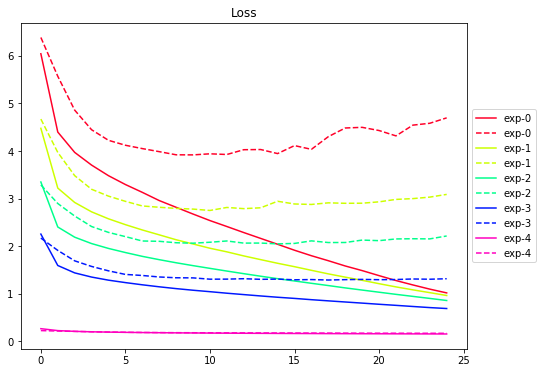

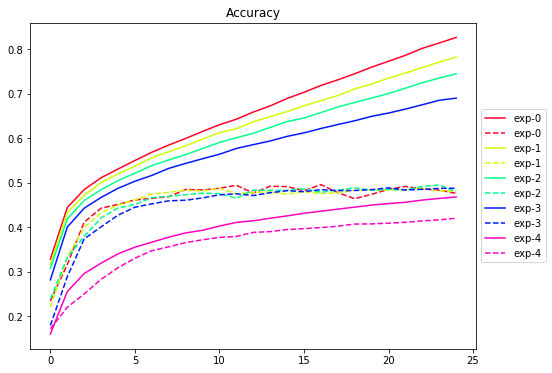

In [39]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [1]:
d = [[[1,2],[3,4],[5,6]],[[7,8],[9,10],[11,12]]]  

In [4]:
d.shape

AttributeError: 'list' object has no attribute 'shape'

In [5]:
import numpy as np
d = np.array([[[1,2],[3,4],[5,6]],[[7,8],[9,10],[11,12]]])

In [7]:
d.shape

(2, 3, 2)

In [8]:
d

array([[[ 1,  2],
        [ 3,  4],
        [ 5,  6]],

       [[ 7,  8],
        [ 9, 10],
        [11, 12]]])

In [14]:
import tensorflow as tf
tf.reduce_max(d, axis=2)

<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[ 2,  4,  6],
       [ 8, 10, 12]])>